# PCA for anomaly detection

In [40]:
import scipy.io
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score, auc, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.cluster 
import sklearn.model_selection 
import sklearn.linear_model
mat = scipy.io.loadmat('satimage-2.mat')

In [41]:
## Preparing data

X = pd.DataFrame(mat['X'])
y = pd.DataFrame(mat['y'])
y.columns = ['Class']
X = preprocessing.scale(X)
y['Class'] = y['Class'].apply(int)



In [42]:
def get_eigen(mat):
    """Returns eigenvalues/eigenvectors in decreasing order of eigenvalues"""
    eigenval, eigenvec = np.linalg.eigh(mat)
    eigenvec = eigenvec.T
    zipped = zip(eigenval,eigenvec)
    eigenvec = [x for _,x in sorted(zipped, key = lambda y : y[0], reverse = True)]
    eigenval = sorted(eigenval, reverse = True)
    
    return eigenval, eigenvec 

def get_nbr_components(X,threshold, plot = False):
    """Given a variance threshold, returns the number of components necessary to go beyond it. 
       Also plots the explained variance graph if plot = True"""
    
    sigma = np.cov(X.T)
    eigenval, eigenvec  = get_eigen(sigma)
    explained_var = np.cumsum(eigenval)/np.sum(eigenval)
    nbr_components = 0
    for i in range(len(explained_var)):
        if explained_var[i] > threshold:
            nbr_components = i
            break      
    if plot:
        plt.plot([0] + list(explained_var))
        plt.xlabel('Number of components')
        plt.ylabel('Variance')
        
    return(nbr_components, sigma, eigenvec)
    

In [43]:
def pca(X,threshold):
    """Given a variance threshold, returns the observations in the principal components basis"""
    k, sigma_hat, eigenvec = get_nbr_components(X,threshold, plot = False)
    eigenvec_pca = eigenvec[:k]
    X_pca = np.dot(np.array(eigenvec_pca),X.T)
    
    return(X_pca)

# DATA VISUALISATION

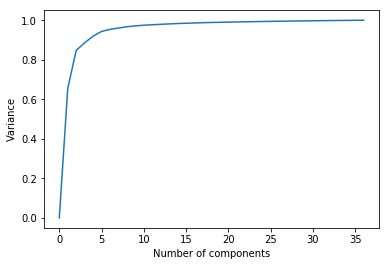

In [44]:
### Explained variance plot
nbr_components, sigma, eigenvec = get_nbr_components(X,0.85, plot = True)

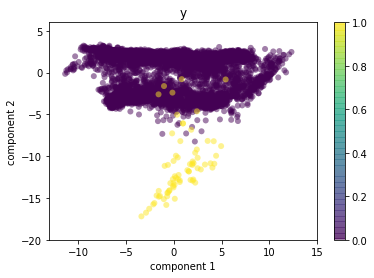

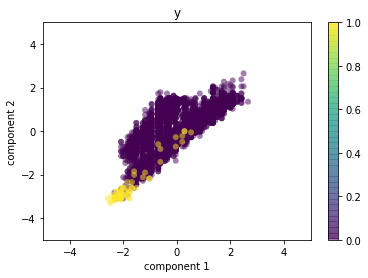

In [45]:
X_pca = pca(X,0.85)

### Displaying data in 2-dimensional space of the 2 principal components
plt.figure(1)
plt.scatter(X_pca.T[:, 0], X_pca.T[:, 1], c= y['Class'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('y')
plt.axis([-13,15,-20,6])
plt.colorbar();


### Displaying data in 2-dimensional space of the 2 first
plt.figure(2)
plt.scatter(X[:, 0], X[:, 1], c= y['Class'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('y')
plt.axis([-5,5,-5,5])
plt.colorbar();

# MAHALANOBIS DISTANCE

In [48]:
def MahalanobisDist(X_pca, verbose=False):
    """Computes the vector of mahalanobis distances associated to each point"""
    inv_covariance_matrix = np.linalg.inv(np.cov(X_pca))
    vars_mean = X_pca.mean(axis=0)
    diff = X_pca - np.array(vars_mean)
    md = []
    for i in range(diff.shape[1]):
        md.append(np.sqrt(diff[:,i].dot(inv_covariance_matrix).dot(diff[:,i])))
        
    return md


def anomaly(X_pca, contamination):  # rate of contamination between 0 and 1
    """Implementation of the classification algorithm based on Mahalanobis
       As an input: the PCA transformed data
       Returns a vector storing the indexes of the outliers, given a previously known contamination rate"""
    vec_id = []
    p,n = X_pca.shape          
    nbr_outlier = int(contamination*n)
    X_alpha = np.copy(X_pca)
    d = dict()
    for i in range(n):    ### Dictionary that stores the original indexes of the observations, as they are dropped during the algorithm
        d.update({X_pca[:,i][0] : i})
    
    for i in range(nbr_outlier):
        md = MahalanobisDist(X_alpha, verbose=False) 
        mean_ = np.array(md).mean(axis=0)
        j = np.argmax(abs(np.array(md)-mean_))  ## Biggest outlier
        vec_id.append(d[X_alpha[:,j][0]])
        X_alpha = np.delete(X_alpha, j, 1)   ## Delete the outlier from the data set
            
    return vec_id


def get_y_hat(vec_id):
    """Transforms output of anomaly to label vector"""
    res = [0]*X.shape[0]
    for i in vec_id:
        res[i] = 1
        
    return res


def get_metrics_mahalan(X,threshold, contamination):
    """Applies the algorithm and computes various metrics"""
    
    X_pca = pca(X,threshold)
    vec_id = anomaly(X_pca, contamination)
    y_hat = get_y_hat(vec_id)
    
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    
    for i in range(len(y_hat)):
        if y['Class'][i] == 0:
            if y_hat[i] == 0:
                true_neg += 1
            else :
                false_pos += 1
        else:
            if y_hat[i] == 1:
                true_pos += 1
            else :
                false_neg += 1
     
    return true_pos, true_neg, false_pos, false_neg, len(y_hat)

In [49]:
get_metrics_mahalan(X,0.85,0.008)

(44, 5731, 1, 27, 5803)

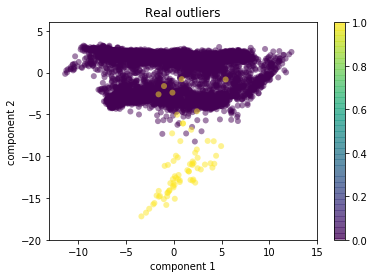

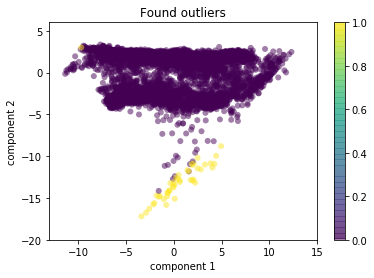

In [92]:
X_pca = pca(X,0.85)
vec_id = anomaly(X_pca, 0.008)
y_hat = get_y_hat(vec_id)

### Displaying data in 2-dimensional space of the 2 principal components
plt.figure(1)
plt.scatter(X_pca.T[:, 0], X_pca.T[:, 1], c= y['Class'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Real outliers')
plt.axis([-13,15,-20,6])
plt.colorbar();


### Displaying data in 2-dimensional space of the 2 first
plt.figure(2)
plt.scatter(X_pca.T[:, 0], X_pca.T[:, 1], c= y_hat, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Found outliers')
plt.axis([-13,15,-20,6])
plt.colorbar();

# K-MEANS

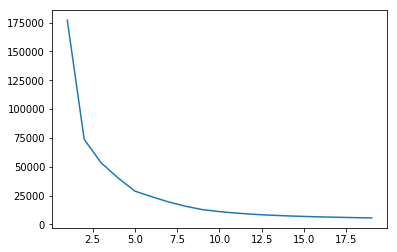

In [50]:
X_pca = pca(X,0.85)

def elbow_curve(X_pca):
    """Plots the elbow curve associated to the k-means algorithm"""
    inertia = []
    for k in range(1,20):
        km = sklearn.cluster.KMeans(n_clusters=k, init='k-means++').fit(X_pca.T)
        inertia.append(km.inertia_)
    
    plt.plot(range(1,20), inertia)
    
    
elbow_curve(X_pca) 

11


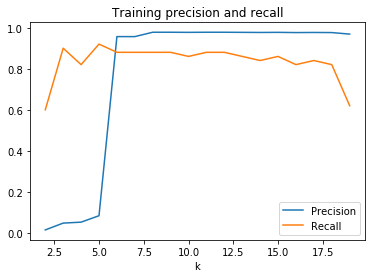

In [71]:

X_pca = pca(X,0.85)  ##Previously apply PCA (2 components --> 0.85 explained variance)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_pca.T,y, test_size = 0.3, 
                                                                            train_size = 0.7, 
                                                                            stratify = y)


def fit(X_train, y_train):
    """Fits the model in order to find the right number k of clusters"""
    
    
    y_train = y_train.values
    md = MahalanobisDist(X_train.T, verbose=False)
    mean_ = np.array(md).mean(axis=0)
    j = np.argmax(abs(np.array(md)-mean_))
    score = []
    precision = []
    recall = []
    outliers_length = []
    for k in range(2,20):
        km = sklearn.cluster.KMeans(n_clusters=k, init='k-means++').fit(X_train)
        labels = km.labels_
        outliers = [i for i in range(len(labels)) if labels[i] == labels[j]]
        outliers_length.append(len(outliers))
        y_hat = [0]*len(y_train)
        for i in outliers:
            y_hat[i] = 1
        
        true_pos = 0
        true_neg = 0
        false_pos = 0
        false_neg = 0
        for i in range(len(y_train)):
            if y_train[i] == 0:
                if y_hat[i] == 0:
                    true_neg += 1
                else :
                    false_pos += 1
            else:
                if y_hat[i] == 1:
                    true_pos += 1
                else :
                    false_neg += 1
              
        #plt.figure(k)
        #plt.scatter(X_train[:, 0], X_train[:, 1], c= labels, edgecolor='none', alpha=0.5)
        #plt.xlabel('component 1')
        #plt.ylabel('component 2')
        #plt.title('y_hat')
        #plt.axis([-13,15,-20,6]) 
        precision.append(true_pos/(true_pos + false_pos))
        recall.append(true_pos/(true_pos + false_neg))
        score.append(float(true_pos)/(true_pos + false_pos + false_neg))

    
    plt.figure(0)
    plt.plot(range(2,20), precision, label = 'Precision')
    plt.plot(range(2,20), recall, label = 'Recall')
    plt.legend(loc = 'best')
    plt.xlabel('k')
    plt.title('Training precision and recall')
    
    
    list_k = np.argwhere(score == np.amax(score))
    return (list_k[len(list_k)//2][0] + 2)

    
print(fit(X_train, y_train))

precision = 1.0
recall = 0.9047619047619048


(19, 1720, 0, 2)

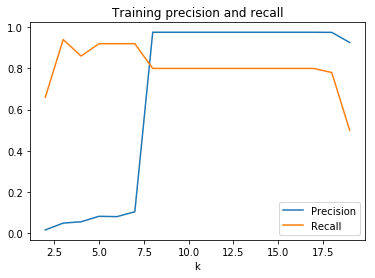

In [183]:
def get_metrics_kmeans():
    """Fits the model, applies the kmeans algorithm to the testing set and gets the metrics"""
    X_pca = pca(X,0.85)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_pca.T,y, test_size = 0.3, 
                                                                            train_size = 0.7, 
                                                                            stratify = y)
    k = fit(X_train, y_train)

    md = MahalanobisDist(X_test.T, verbose=False)
    mean_ = np.array(md).mean(axis=0)
    j = np.argmax(abs(np.array(md)-mean_))
    km = sklearn.cluster.KMeans(n_clusters=k, init='k-means++').fit(X_test)
    labels = km.labels_
    outliers = [i for i in range(len(labels)) if labels[i] == labels[j]]
    y_hat = [0]*len(y_test['Class'])
    for i in outliers:
        y_hat[i] = 1
        
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    for i in range(len(y_test['Class'])):
        if y_test['Class'].iloc[i] == 0:
            if y_hat[i] == 0:
                true_neg += 1
            else :
                false_pos += 1
        else:
            if y_hat[i] == 1:
                true_pos += 1
            else :
                false_neg += 1
                
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    
    print ('precision = ' + str(precision))
    print ('recall = ' + str(recall))
    return true_pos, true_neg, false_pos, false_neg

get_metrics_kmeans()

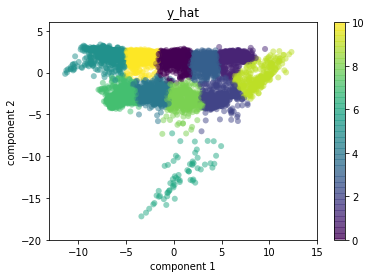

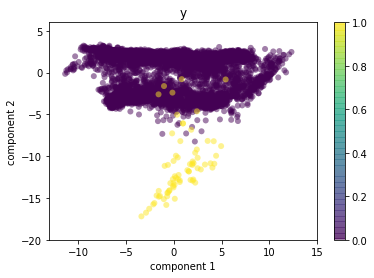

In [181]:
X_pca = pca(X,0.95)
 
km = sklearn.cluster.KMeans(n_clusters=11, init='k-means++').fit(X_pca.T)
labels = km.labels_



plt.figure(0)
plt.scatter(X_pca.T[:, 0], X_pca.T[:, 1], c= labels, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('y_hat')
plt.axis([-13,15,-20,6])
plt.colorbar();


plt.figure(1)
plt.scatter(X_pca.T[:, 0], X_pca.T[:, 1], c= y['Class'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('y')
plt.axis([-13,15,-20,6])
plt.colorbar();

# LOGREG

precision = 1.0
recall = 0.9285714285714286


C:\Users\Oualid\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Oualid\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

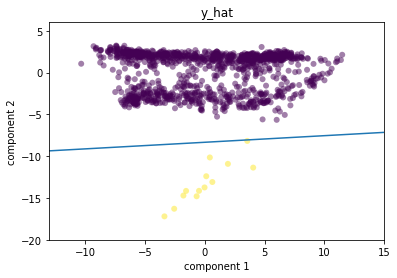

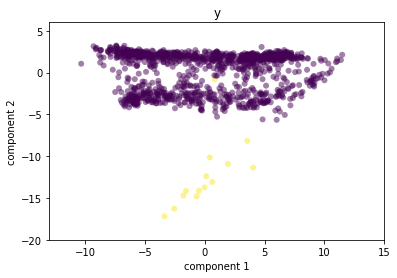

In [189]:
### Perform a logistic regression after PCA

X_pca = pca(X,0.85)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_pca.T,y, test_size = 0.2, 
                                                                            train_size = 0.8, 
                                                                            stratify = y)
### Apply the algorithm (log reg)

log_reg =  sklearn.linear_model.LogisticRegression()
log_reg.fit(X_train, y_train)
y_hat = log_reg.predict(X_test)


### Compute metrics

true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0
for i in range(len(np.array(y_test))):
    if np.array(y_test)[i] == 0:
        if y_hat[i] == 0:
            true_neg += 1
        else :
            false_pos += 1
    else:
        if y_hat[i] == 1:
            true_pos += 1
        else :
            false_neg += 1
                
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)

    
print ('precision = ' + str(precision))
print ('recall = ' + str(recall))

### Get the coefficients of the regression

coeff = log_reg.coef_[0]
intercept = log_reg.intercept_[0]



plt.figure(0)
plt.scatter(X_test[:, 0], X_test[:, 1], c = y_hat, edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('y_hat')
plt.axis([-13,15,-20,6])

### Plot the decision boundary

x_absc = np.linspace(-13,15,1000)
plt.plot( x_absc, [(-coeff[0]/coeff[1])*x - intercept/coeff[1] for x in x_absc])



plt.figure(1)
plt.scatter(X_test[:, 0], X_test[:, 1], c= y_test['Class'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('y')
plt.axis([-13,15,-20,6])


